In [1]:
from google.colab import drive
drive.mount('/content/drive')

with open('/content/drive/My Drive/Mount.txt', 'r') as file:
    mount = file.read()

print(mount)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive
Mount successful!


In [0]:
import numpy as np
import tensorflow as tf
from tensorflow import keras

# Display
from IPython.display import Image
import matplotlib.pyplot as plt
import cv2

In [0]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping, ModelCheckpoint
from tensorflow.keras import optimizers
import datetime
from os import listdir, mkdir
from os.path import isfile, isdir, join, exists
import pickle
import random
import math
import time

def seconds_to_m_s(seconds):
    minutes = math.floor(seconds // 60)
    seconds = math.ceil(seconds % 60)
    return minutes, seconds

base_dir = '/content/drive/My Drive/BF_dataset'

In [0]:
from tensorflow.keras import backend as K
K.clear_session()

In [0]:
def get_img_array(img_path, size):
  # `img` is a PIL image of size 224x224
  img = keras.preprocessing.image.load_img(img_path, target_size=size)
  # `array` is a float32 Numpy array of shape (224, 224, 3)
  array = keras.preprocessing.image.img_to_array(img)
  # We add a dimension to transform our array into a "batch"
  # of size (1, 224, 224, 3)
  array = np.expand_dims(array, axis=0)
  return array

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, classifier_layer_names):
  # First, we create a model that maps the input image to the activations
  # of the last conv layer
  last_conv_layer = model.get_layer(last_conv_layer_name)
  # last_conv_layer_model = keras.Model(model.inputs, last_conv_layer.output)
  # model.get_layer('vgg16').get_layer('input_3')
  last_conv_layer_model = keras.Model(inputs=model.inputs, outputs=last_conv_layer.output)
  
  # Second, we create a model that maps the activations of the last conv
  # layer to the final class predictions
  classifier_input = keras.Input(shape=last_conv_layer.output.shape[1:])
  x = classifier_input
  for layer_name in classifier_layer_names:
    x = model.get_layer(layer_name)(x)
  classifier_model = keras.Model(classifier_input, x)

  # Then, we compute the gradient of the top predicted class for our input image
  # with respect to the activations of the last conv layer
  with tf.GradientTape() as tape:
    # Compute activations of the last conv layer and make the tape watch it
    last_conv_layer_output = last_conv_layer_model(img_array)
    tape.watch(last_conv_layer_output)
    # Compute class predictions
    preds = classifier_model(last_conv_layer_output)
    top_pred_index = tf.argmax(preds[0])
    top_class_channel = preds[:, top_pred_index]

  # This is the gradient of the top predicted class with regard to
  # the output feature map of the last conv layer
  grads = tape.gradient(top_class_channel, last_conv_layer_output)

  # This is a vector where each entry is the mean intensity of the gradient
  # over a specific feature map channel
  pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

  # We multiply each channel in the feature map array
  # by "how important this channel is" with regard to the top predicted class
  last_conv_layer_output = last_conv_layer_output.numpy()[0]
  pooled_grads = pooled_grads.numpy()
  for i in range(pooled_grads.shape[-1]):
    last_conv_layer_output[:, :, i] *= pooled_grads[i]

  # The channel-wise mean of the resulting feature map
  # is our heatmap of class activation
  heatmap = np.mean(last_conv_layer_output, axis=-1)

  # For visualization purpose, we will also normalize the heatmap between 0 & 1
  heatmap = np.maximum(heatmap, 0) / np.max(heatmap)
  return heatmap

In [5]:
from tensorflow.keras.models import load_model
preprocess_input = keras.applications.vgg16.preprocess_input

last_conv_layer_name = 'conv2d_12'
classifier_layer_names = [
  'max_pooling2d_4',
  'flatten',
  'batch_normalization',
  'dense',
  'batch_normalization_1',
  'dense_1']

# Make model
model = load_model(join(base_dir, 'model_tank5_unfreeze5_03.h5'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 224, 224, 64)      1792      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 224, 224, 64)      36928     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 64)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 112, 112, 128)     73856     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 112, 112, 128)     147584    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 56, 56, 128)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 56, 56, 256)       2

In [0]:
image_name = 'f_m1a2_s_0972.png'
img_path = join(base_dir, '04_Field_v', '00_m1a2', image_name)

# Prepare image
img_array = preprocess_input(get_img_array(img_path, size=(224, 224)))

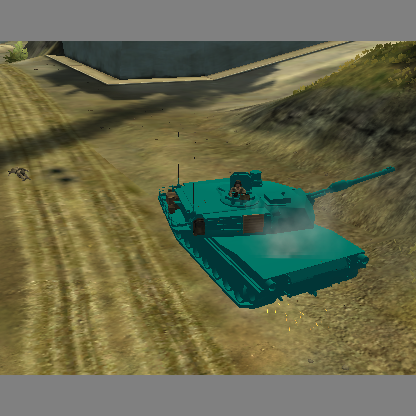

In [0]:
display(Image(img_path))

In [0]:
# Print what the top predicted class is
preds = model.predict(img_array)
print('Predicted:', np.argmax(preds[0]), preds[0])

# Generate class activation heatmap
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name, classifier_layer_names)

# Display heatmap
# plt.matshow(heatmap)
# plt.show()

Predicted: 1 [2.2462338e-20 1.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00]


In [0]:
# We use cv2 to load the original image
img = cv2.imread(img_path)

# We resize the heatmap to have the same size as the original image
heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))

# We convert the heatmap to RGB
heatmap = np.uint8(255 * heatmap)

# We apply the heatmap to the original image
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

# 0.4 here is a heatmap intensity factor
superimposed_img = heatmap * 0.4 + img

# Save the image to disk
save_path = join(base_dir, '{}_heat.png'.format(image_name.split('.')[0]))
cv2.imwrite(save_path, superimposed_img)

True

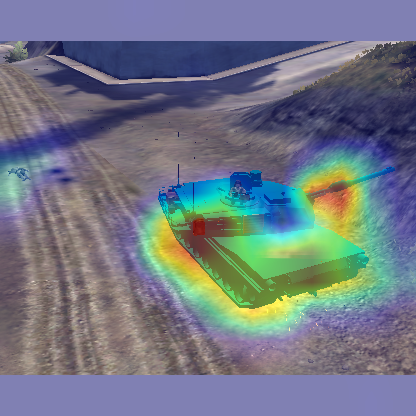

In [0]:
display(Image(save_path))

In [0]:
# ----------------------------------------------
#            ***  DIRECTORY  ***
base_dir = '/content/drive/My Drive/BF_dataset'
original_dir = join(base_dir, '04_Field_v')
out_yes_dir = join(base_dir, 'Correct')
out_no_dir = join(base_dir, 'Wrong')
# ==============================================
if not exists(out_yes_dir):
    mkdir(out_yes_dir)

if not exists(out_no_dir):
    mkdir(out_no_dir)

folder_list = [dir for dir in listdir(original_dir) if isdir(join(original_dir, dir))]
# ==============================================

# ----------------------------------------------
#          ***  CHECK IMAGES  ***
for class_ind, folder in enumerate(folder_list):
    current_dir = join(original_dir, folder)

    cur_out_yes_dir = join(out_yes_dir, folder)

    if not exists(cur_out_yes_dir):
        mkdir(cur_out_yes_dir)

    cur_out_no_dir = join(out_no_dir, folder)

    if not exists(cur_out_no_dir):
        mkdir(cur_out_no_dir)

    folder_images_list = [f for f in listdir(current_dir) if isfile(join(current_dir, f))]
    print('\n{}: {}'.format(folder, len(folder_images_list)))

    for img_ind in range(len(folder_images_list)):
        img_name = folder_images_list[img_ind]
        print('\n{0}/{1} Image name: {2}'.format(img_ind + 1, len(folder_images_list), img_name))
     
        img_array =  preprocess_input(get_img_array(join(current_dir, img_name), (224, 224)))
        heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name, classifier_layer_names)

        # We use cv2 to load the original image
        # img = cv2.imread(img)
        img = cv2.imread(join(current_dir, img_name))

        # We resize the heatmap to have the same size as the original image
        heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))

        # We convert the heatmap to RGB
        heatmap = np.uint8(255 * heatmap)

        # We apply the heatmap to the original image
        heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

        # 0.4 here is a heatmap intensity factor
        superimposed_img = heatmap * 0.4 + img

        # Save the image to disk 
        save_path = join(cur_out_yes_dir, img_name)

        cv2.imwrite(save_path, superimposed_img)

    #     if (img_ind + 1) % 10 == 0:
    #         break        
    # break

# ==============================================


00_m1a2: 300

1/300 Image name: f_m1a2_s_0901.png


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:58: RuntimeWarning: invalid value encountered in true_divide



2/300 Image name: f_m1a2_s_0900.png

3/300 Image name: f_m1a2_s_0902.png

4/300 Image name: f_m1a2_s_0904.png

5/300 Image name: f_m1a2_s_0903.png

6/300 Image name: f_m1a2_s_0907.png

7/300 Image name: f_m1a2_s_0905.png

8/300 Image name: f_m1a2_s_0906.png

9/300 Image name: f_m1a2_s_0910.png

10/300 Image name: f_m1a2_s_0908.png

11/300 Image name: f_m1a2_s_0909.png

12/300 Image name: f_m1a2_s_0912.png

13/300 Image name: f_m1a2_s_0911.png

14/300 Image name: f_m1a2_s_0913.png

15/300 Image name: f_m1a2_s_0914.png

16/300 Image name: f_m1a2_s_0915.png

17/300 Image name: f_m1a2_s_0917.png

18/300 Image name: f_m1a2_s_0918.png

19/300 Image name: f_m1a2_s_0916.png

20/300 Image name: f_m1a2_s_0921.png

21/300 Image name: f_m1a2_s_0919.png

22/300 Image name: f_m1a2_s_0920.png

23/300 Image name: f_m1a2_s_0923.png

24/300 Image name: f_m1a2_s_0924.png

25/300 Image name: f_m1a2_s_0922.png

26/300 Image name: f_m1a2_s_0927.png

27/300 Image name: f_m1a2_s_0925.png

28/300 Image name: 

In [0]:
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
from numpy import expand_dims
import pickle

def prepare_image(img_name):
	image = load_img(img_name, target_size=(224, 224))
	image = img_to_array(image)
	image = image.astype('float32')
	image /= 255.0
	image = expand_dims(image, 0)
	return image

In [9]:
base_dir = '/content/drive/My Drive/BF_dataset'
validation_dir = join(base_dir, '04_Field_v')

from os import listdir, mkdir
from os.path import isfile, isdir, join, exists
import pickle
import numpy as np

predictions = {}
no_correct = []
correct = []

val_list_folders = [dir for dir in listdir(validation_dir) if isdir(join(validation_dir, dir))]

for val_folder_ind in range(len(val_list_folders)):
    val_folder = val_list_folders[val_folder_ind]
    current_dir = join(validation_dir, val_folder)

    folder_files = [f for f in listdir(current_dir) if isfile(join(current_dir, f))]

    for img_ind in range(len(folder_files)):
        img_name = folder_files[img_ind]
        print('\n{0}/{1} Image name: {2}'.format(img_ind+1, len(folder_files), img_name))

        yhat = model.predict(prepare_image(join(current_dir, img_name)))
        print(yhat)

        predictions[img_name] = yhat

        if np.argmax(yhat) != val_folder_ind:
            no_correct.append(img_name)
        else:
            correct.append(img_name)


file = open(join(base_dir, 'tanks5_corhaet_pred.p'), 'wb')
pickle.dump(predictions, file)
file.close()

file = open(join(base_dir, 'tanks5_corhaet_no_correct.p'), 'wb')
pickle.dump(no_correct, file)
file.close()

file = open(join(base_dir, 'tanks5_corhaet_correct.p'), 'wb')
pickle.dump(correct, file)
file.close()

print('Save data!')
print(len(no_correct))
print(len(correct))

# Save data!
# 154
# 1346


1/300 Image name: f_m1a2_s_0901.png
[[9.8914343e-01 6.2726863e-04 7.2261449e-03 2.4754279e-03 5.2769878e-04]]

2/300 Image name: f_m1a2_s_0900.png
[[9.7102261e-01 1.7920508e-04 2.6383663e-05 2.8756307e-02 1.5464442e-05]]

3/300 Image name: f_m1a2_s_0902.png
[[6.6602844e-01 4.0574832e-04 1.6539829e-03 3.3007640e-01 1.8355327e-03]]

4/300 Image name: f_m1a2_s_0904.png
[[4.32647198e-01 1.51910877e-03 3.53352982e-03 5.62188029e-01
  1.12153095e-04]]

5/300 Image name: f_m1a2_s_0903.png
[[9.9930334e-01 4.5771818e-04 1.7724564e-05 2.0563354e-04 1.5547092e-05]]

6/300 Image name: f_m1a2_s_0907.png
[[8.6700875e-01 7.1822351e-04 1.5225534e-04 3.9684940e-02 9.2435889e-02]]

7/300 Image name: f_m1a2_s_0905.png
[[9.9473649e-01 1.4033244e-03 2.2098150e-04 3.5117671e-03 1.2736261e-04]]

8/300 Image name: f_m1a2_s_0906.png
[[2.8635615e-01 7.9912290e-02 1.9668341e-04 6.2409222e-01 9.4427131e-03]]

9/300 Image name: f_m1a2_s_0910.png
[[9.9840528e-01 4.6154495e-05 9.2489099e-06 1.4743102e-03 6.4962012e